In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sksurv.datasets import load_gbsg2, load_whas500, load_aids
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder

import shap

/home/dmachlan/RDS/miniconda3/envs/ssp25/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## GBSG 2

### Modeling

In [9]:
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

Xt.rename(columns={'horTh=yes': 'horTh', 'menostat=Post': 'menostat'}, inplace=True)

random_state = 20
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)

rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=random_state
)

rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

### Feature importance

In [11]:
result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=random_state)

df = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
)

df = df.reset_index()

### SHAP

In [12]:
eps = 1.0
X_mean = X_test.mean().to_frame().T

y_mean = rsf.predict(X_mean)
y_pred = rsf.predict(X_test)

sel_mask = np.abs(y_pred - y_mean) < eps

# use the reference point
ex = shap.KernelExplainer(rsf.predict, X_mean)

# get SHAP values of the selected individuals (delta_R close to 0)
ex_result = ex(X_test[sel_mask])

100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


### Plots

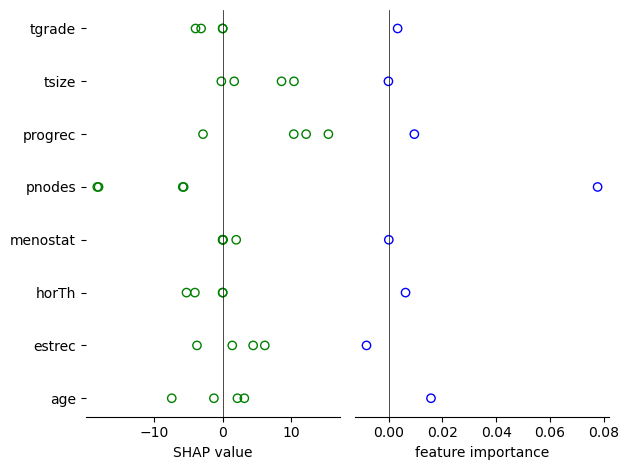

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)

for v in ex_result.values:
    ax1.scatter(v, X_test.columns, facecolors='none', edgecolors='g')

ax1.axvline(0.0, c='k', linewidth=0.5)
ax1.set_xlabel('SHAP value')
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)


ax2.scatter(df['importances_mean'], df['index'], facecolors='none', edgecolors='b')
ax2.set_yticks([]) # comment out to check if the features match with the first plot
ax2.axvline(0.0, c='k', linewidth=0.5)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('feature importance')

plt.tight_layout()
plt.savefig('plots/gbsg2.pdf', dpi=1000)